# Random Forest
Gudenas data

In [1]:
from datetime import datetime
print(datetime.now())

2023-07-13 09:48:55.087558


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/'  # must end in "/"
except:
    IN_COLAB = False
    print('Running on Mac')
    DATA_DIR="/Users/jasonmiller/WVU/Localization/"

2023-07-13 09:48:55.136563: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU device not found
Running on Mac


2023-07-13 09:49:04.485213: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from platform import python_version
print('Python',python_version())
import random
import numpy as np
np.random.seed(42) # supposedly sets scikit-learn
import pandas as pd  # for plotting
import time # sleep function
from os.path import isfile
import gzip
from matplotlib import pyplot as plt
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
# consider sklearn.metrics.classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier as RFC

Python 3.10.0
sklearn 1.1.2


## Data Load

In [4]:
MAX_LINES_TO_LOAD =    10 # use this for debugging

VALID_PORTION = 0.20

DATA_FILE_0 = 'Gudenas/Gudenas.Supplement.Data1.csv'

print('Data directory: %s'%DATA_DIR)
print('Data file 0 %s'%DATA_FILE_0)
print('Input lines for training: %d'%MAX_LINES_TO_LOAD)

Data directory: /Users/jasonmiller/WVU/Localization/
Data file 0 Gudenas/Gudenas.Supplement.Data1.csv
Input lines for training: 10


In [5]:
class DataLoader():
    def __init__(self,filepath1,verbose=True):
        self.file = filepath1
        self.verbose = verbose
        self.max_lines = None

    def set_max_lines(self,lines):
        '''Limit the dataset size to fit in RAM.'''
        self.max_lines = lines
        if self.verbose:
            print('Maximum lines to load per file: %d'%lines)

    def load_full_train_set(self):
        minimum = 0
        max_lines = self.max_lines
        num_lines = 0
        header = None
        self.id = []
        self.fold_change = []
        self.label = []
        self.feature = []
        self.names = []
        try:
            with open(self.file,'r') as fin:
                for line in fin:
                    line=line.strip()
                    fields=line.split(',')
                    if header is None:
                        header = fields
                        id = header.pop(0)
                        fold = header.pop(0)
                        label = header.pop(-1)
                        self.names.append(fields)
                        continue
                    if max_lines is not None and num_lines >= max_lines:
                        break
                    num_lines += 1
                    self.id.append(fields.pop(0))
                    self.fold_change.append(fields.pop(0))
                    label = fields.pop(-1)
                    if label=='Cytosol':
                        binary = 0
                    else:
                        binary = 1
                    self.label.append(binary)
                    fields[1]=100.0*float(fields[1])+0.5  # GC content
                    ints = list(map(int,fields))
                    self.feature.append(ints)
        except Exception as e:
            print(e)
            raise Exception('CANNOT LOAD DATA FROM FILE!')
            
    def get_names(self):
        return self.names

    def show_examples(self,how_many=3):
        for i in range(how_many):
            print(self.id[i], self.fold_change[i],self.label[i])
            print(self.feature[i][:5],'...',self.feature[i][-5:])

    def get_X_y(self):
        length = len(self.label)
        X_train = []
        y_train = []
        X_valid = []
        y_valid = []
        skip = 0
        for i in range(length):
            skip += 1
            if skip == 5:
                X_valid.append(self.feature[i])
                y_valid.append(self.label[i])
                skip = 0
            else:
                X_train.append(self.feature[i])
                y_train.append(self.label[i])
        X_train = np.asarray(X_train)
        y_train = np.asarray(y_train)
        X_valid = np.asarray(X_valid)
        y_valid = np.asarray(y_valid)
        return X_train,y_train, X_valid,y_valid

In [6]:
print(datetime.now())
filepath0 = DATA_DIR+DATA_FILE_0
loader=DataLoader(filepath0)
#loader.set_max_lines(MAX_LINES_TO_LOAD)
print('LOADING')
loader.load_full_train_set()
loader.show_examples()

2023-07-13 09:49:06.852110
LOADING
ENST00000446102 -0.521941851 0
[1363, 44, 111, 70, 99] ... [0, 0, 0, 0, 0]
ENST00000421020 -0.103359064 0
[755, 41, 58, 39, 51] ... [0, 0, 0, 0, 0]
ENST00000428895 -3.3740969 0
[1479, 46, 95, 72, 111] ... [0, 0, 0, 0, 0]


In [7]:
X_train,y_train, X_valid,y_valid = loader.get_X_y()
print('X train shape: ')
print(np.shape(X_train))
print('y train shape: ')
print(np.shape(y_train))
print('X valid shape: ')
print(np.shape(X_valid))
print('y valid shape: ')
print(np.shape(y_valid))

X train shape: 
(6943, 1582)
y train shape: 
(6943,)
X valid shape: 
(1735, 1582)
y valid shape: 
(1735,)


## Model

In [8]:
def build_model():
    rfc = RFC()
    return rfc

In [9]:
print(datetime.now())
rfc_model=build_model()
print(rfc_model)

2023-07-13 09:49:10.619119
RandomForestClassifier()


## Training

In [10]:
print(datetime.now())
print("FIT")
rfc_model.fit(X_train, y_train) # sample weight
print(datetime.now())

2023-07-13 09:49:10.639448
FIT
2023-07-13 09:49:18.175665


## Validation

In [11]:
print(datetime.now())
print("PREDICT")
yhat_pairs=rfc_model.predict_proba(X_valid)  # [ prob of 0, prob of 1 ]
yhat_pred=[pair[1] for pair in yhat_pairs]
yhat_classes=rfc_model.predict(X_valid)  # 0 or 1

print('debug pred',yhat_pred[:3])
print('debug class',yhat_classes[:3])
print(datetime.now())

2023-07-13 09:49:18.185540
PREDICT
debug pred [0.57, 0.19, 0.57]
debug class [1 0 1]
2023-07-13 09:49:18.434901


In [12]:
# docs: Note that in binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.
def show_performance(y_valid, yhat_classes, yhat_pred):
    accuracy = accuracy_score(y_valid, yhat_classes)*100.
    precision = precision_score(y_valid, yhat_classes)*100.
    recall = recall_score(y_valid, yhat_classes)*100.
    sensitivity = recall_score(y_valid, yhat_classes, pos_label=1)*100.
    specificity = recall_score(y_valid, yhat_classes, pos_label=0)*100.
    f1 = f1_score(y_valid, yhat_classes)*100.
    mcc = matthews_corrcoef(y_valid, yhat_classes)
    if yhat_pred is None:
        # these stats are possible for probabilistic models only
        auprc = 0.
        auroc = 0.
    else:
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_valid, yhat_pred)*100.
    values,counts=np.unique(yhat_classes, return_counts=True)
    print('Predictions: ', dict(zip(values, counts)))
    print('Accuracy: %.2f%% F1: %.2f%% MCC: %.4f' % (accuracy,f1,mcc))
    print('Precision: %.2f%% Recall: %.2f%% AUPRC: %.2f%%' % (precision,recall,auprc))
    print('Sensitivity: %.2f%% Specificity: %.2f%% AUROC: %.2f%%' % (sensitivity,specificity,auroc))


In [13]:
print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
cm1 = confusion_matrix(y_valid,yhat_classes)
print('Confusion matrix\n',cm1)
cm2 = confusion_matrix(y_valid,yhat_classes,normalize='all')
print('Normalized matrix\n',cm2)

show_performance(y_valid, yhat_classes, yhat_pred)

Distrib of scores: 0.49806340057636894 mean 0.1725220497554926 std
Range of scores: 0.0 to 0.93
Confusion matrix
 [[589 298]
 [228 620]]
Normalized matrix
 [[0.33948127 0.17175793]
 [0.1314121  0.3573487 ]]
Predictions:  {0: 817, 1: 918}
Accuracy: 69.68% F1: 70.22% MCC: 0.3957
Precision: 67.54% Recall: 73.11% AUPRC: 75.13%
Sensitivity: 73.11% Specificity: 66.40% AUROC: 77.49%


## Feature Importance

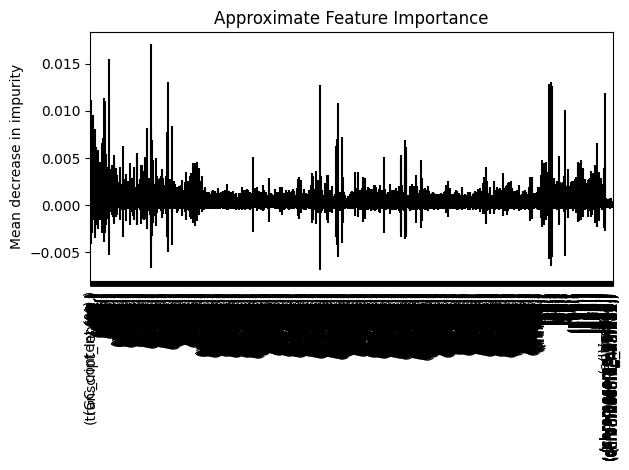

In [15]:
importances = rfc_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc_model.estimators_], axis=0)
feature_names = loader.get_names()
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Approximate Feature Importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [16]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(forest_importances)

transcript_length    0.001631
GC_content (%)       0.003557
AA                   0.002189
AC                   0.001229
AG                   0.001518
AT                   0.001738
CA                   0.002601
CC                   0.001497
CG                   0.004275
CT                   0.001689
GA                   0.001420
GC                   0.001554
GG                   0.001198
GT                   0.002325
TA                   0.001960
TC                   0.001864
TG                   0.002019
TT                   0.001340
AAA                  0.001448
AAC                  0.001353
AAG                  0.001488
AAT                  0.001525
ACA                  0.001418
ACC                  0.001431
ACG                  0.002127
ACT                  0.001057
AGA                  0.001151
AGC                  0.001049
AGG                  0.001333
AGT                  0.001471
ATA                  0.001595
ATC                  0.001014
ATG                  0.001269
ATT       

In [17]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    its = forest_importances.sort_values()
    print(its)

chromosome_nameY     0.000000
217                  0.000000
145                  0.000000
176                  0.000058
chromosome_name20    0.000072
chromosome_name16    0.000074
chromosome_name22    0.000075
chromosome_name13    0.000087
chromosome_name10    0.000088
GGTCG                0.000088
chromosome_nameX     0.000088
154                  0.000094
GTCGG                0.000094
chromosome_name21    0.000095
TCGCA                0.000099
CGACC                0.000103
CGATA                0.000106
183                  0.000116
GCGTG                0.000117
chromosome_name8     0.000118
ATACG                0.000119
chromosome_name18    0.000119
CCGAT                0.000121
chromosome_name9     0.000123
chromosome_name7     0.000129
208                  0.000131
chromosome_name3     0.000132
chromosome_name6     0.000133
ATCGG                0.000136
CGGTA                0.000137
CTACG                0.000141
chromosome_name11    0.000142
AGTCG                0.000143
TACGT     